# [Prominences in the Ideal world][title]

#### by J. Panerati, C. Pinciroli and G. Beltrame

Parto of the submission "From Swarms to Stars" to: Autonomous Robots (S.I. on Distributed Systems)

>Swarm robotics carries the potential of solving complex tasks using simple devices.
One of its the major challenges, however, is the definition of distributed control algorithms capable of producing globally coordinate behaviours. In this work, we proposed a hybrid methodology to address the problem of the spatial coverage of multiple tasks by a swarm of robots that never loses global connectivity.
Our methodology comprises two layers. 
First, a fully distributed Robot Navigation Controller is responsible for simultaneously guaranteeing connectivity and pursuit of multiple tasks.
On top, a global planner (the Task Schedule Generator) approximates an optimal strategy for the RNC with minimal computational load. Our contributions include: (i) a qualitative comparison of the literature on the subject of distributed multi-robot connectivity maintenance, (ii) the implementation of the proposed methodology, (iii) simulations performed in a multi-physics environment, and (iv) formal and experimental assessment of the guarantees on connectivity, pseudo-optimality, and fault-tolerance. 

[title]:https://github.com/JacopoPan/ar-prominences-in-the-ideal-world.git

In [2877]:
%matplotlib inline

In [2878]:
from matplotlib import animation, rc
from IPython.display import HTML
import matplotlib.pyplot as plt
import numpy as np
import os
import math
import random
random.seed(a=None, version=2)

## Parameters

- $N$ is the number of robots
- $L$ is the number of leaders (randomly chosen among the robots)
- $T$ is the number of tasks/targets
- $D$ is the length of the side of the square arena, in meters
- $H$ is the length of the time horizon of the simulation, in seconds
- $control\_step$ is the period (in s) used by the robots/simulation to recompute the robots' velocities and positions
- $propagation$ is the period (in s) at which the robots/simulation broadcast messages to neighbors
- $maxspeed$ is the maximum linear speed of a robot in meters per second
- $radius$ is how far a robot can detect another robot, in meters
- $plot\_sampling$ defines how often the simulation is plotted (in s)

In [2879]:
###########
#parameters
###########

N = 30                 #number of robots
T = 4                 #number of tasks
D = 8                 #size of the arena (in m)
H = 600               #time horizon (in s)
control_step = 1.0    #time step of the control, i.e. recomputation of the velocity vectors (in s)
propagation = 0.1     #time step of the communication, i.e. broadcast of messages to neighbors (in s)
maxspeed = 0.03       #max linear speed of a robot (in m/s)
radius = 1.0          #range of visibility (in m)
plot_sampling = 10    #how often plots are produced (in s)

################
#data structures
################

tasks = np.zeros((T, 2))                #matrix whose rows contain the x,y of each target, initialized with 0s
positions = np.zeros((N, 2))            #matrix whose rows contain the x,y of each robot, initialized with 0s
velocities = np.zeros((N, 2))           #matrix whose rows contain the x',y' of each robot, initialized with 0s

robot_info = 10  
swarm_info = 10
swarm_knowledge = np.zeros((N, robot_info*N+swarm_info)) #matrix keeping what each robot knows

### init()
init() randomly assigns the leader role to $L$ robots, (uniformly) randomly places the tasks in the arena, and the robots in a circle in the center of the arena.
- input: _none_
- output: _none_

In [2880]:
def init():
    for i in range(0,N):
        positions[i,0] = (D/2) + (radius*0.67)*(random.random()-1/2)
        positions[i,1] = (D/2) + (radius*0.67)*(random.random()-1/2)

    for i in range(0,T):
        tasks[i,0] = 0.05*D + 0.9*D*random.random()
        tasks[i,1] = 0.05*D + 0.9*D*random.random()

### neighbors()
neighbors() computes the adjacency matrix A of the swarm, using the value of $radius$
- input: _none_
- output: __A__

In [2881]:
def neighbors():
    A = np.zeros((N,N))         #adjacency matrix, initialized with 0s
    for i in range(0,N):
        for j in range(0,N):
            if ( (positions[i,0]-positions[j,0])**2 + (positions[i,1]-positions[j,1])**2 ) < (radius)**2:
                A[i,j] = 1
    return A

### communicate()
communicate() updates
- input: _none_
- output: _none_

In [2882]:
def communicate(a,t):
    A = a
    for i in range(0,N):
            for j in range(0,N):
                if A[i,j]==1 and i!=j:
                    for k in range(0,robot_info*N+swarm_info):
                        if 0:
                            X = 0                 

## control()
the control() function
- input: _none_
- output: _none_

In [2883]:
def ithtarget(n):
    return tasks[n,:]

def fixPi(badPi):
    #force the offset in the -pi,+pi domain
    goodPi = badPi
    while (goodPi > math.pi) or (goodPi < -math.pi):
        if goodPi > math.pi:
            goodPi = -2.0*math.pi + goodPi 
        elif goodPi < -math.pi:
            goodPi = 2.0*math.pi + goodPi
    return goodPi

inline = np.zeros((N))
    
def control(a):
    A = a
    velocities_bak = velocities
    for i in range(0,N):
        
        total_force = np.zeros((2)) 
        
        ###################################################################
        for j in range(0,N):
            if i!=j and A[i,j]==1 and (j%3)==(i%3):
                direction = positions[i,:]-positions[j,:]
                distance = math.sqrt(np.sum(direction**2))
                
                epsilon = 0.5
                delta = radius*0.5
                force = 0 #potential = 0
                if distance>delta/10:
                    force = ((4*epsilon)/distance)*((delta/distance)**4-(delta/distance)**2)
                    #potential = epsilon*((delta/distance)**4-2*(delta/distance)**2)
                else:
                    force = 100
                
                
                if distance>0.03:
                    total_force = total_force + force*(direction/distance)
                else:
                    random_direction = np.zeros((2))
                    random_direction[0] = 2*(random.random()-0.5)
                    random_direction[1] = 2*(random.random()-0.5)
                    total_force = total_force + force*random_direction
        ###################################################################      
        
        ###################################################################  
        angular_threshold = 0.08
        if i%3==0:
            desired_direction = np.array([1, 1])
        elif i%3==1:
            desired_direction = np.array([-1, 1])
        else:
            desired_direction = np.array([-1, -1])
        
        #the central node
        if i==0:
            total_force = np.array([0, 0])

        #other nodes
        else:
            angle_offset = 0.0 #zero init for nodes who cannot see the central node, nor any aligned node
            
        #who can see the central node
            if A[i,0]==1:
                origin_robot_vector = positions[i,:]-positions[0,:]
                origin_robot_angle = math.atan2(origin_robot_vector[1], origin_robot_vector[0])
                desired_angle = math.atan2(desired_direction[1], desired_direction[0])
                angle_offset = desired_angle - origin_robot_angle
                
        #who can't see the central node
            else:
                aligned_neighbor = -1
                for j in range(0,N):
                    if inline[j]==1 and (j%3)==(i%3):
                        aligned_neighbor = j
                        break
                if aligned_neighbor!=-1:
                    aligned_robot_vector = positions[i,:]-positions[j,:]
                    aligned_robot_angle = math.atan2(aligned_robot_vector[1], aligned_robot_vector[0])
                    desired_angle = math.atan2(desired_direction[1], desired_direction[0])
                    angle_offset = desired_angle - aligned_robot_angle
            
            #fix angle_offset's domain
            angle_offset = fixPi(angle_offset)
            
            #corrections magnitude parameter
            correction_strength = 0.33
        
        
            #robots seeing the central node or ahead of an aligned robot
            if A[i,0]==1 or (aligned_neighbor!=-1 and (angle_offset <=(math.pi/2) and angle_offset>=(-math.pi/2))):
                if angle_offset > math.pi/4 or angle_offset < -math.pi/4:
                    inline[i]=0
                    total_force = correction_strength*(desired_direction/math.sqrt(np.sum(desired_direction**2)))
                elif angle_offset < -angular_threshold:
                    inline[i]=0
                    perpendicular_approach = np.array([desired_direction[1], -desired_direction[0]])
                    total_force = correction_strength*(perpendicular_approach/math.sqrt(np.sum(perpendicular_approach**2)))
                elif angle_offset > angular_threshold:
                    inline[i]=0
                    perpendicular_approach = np.array([-desired_direction[1], desired_direction[0]])
                    total_force = correction_strength*(perpendicular_approach/math.sqrt(np.sum(perpendicular_approach**2)))
                else:
                    inline[i]=1
                    
            #robots behind an aligned robot
            elif aligned_neighbor!=-1:
                desired_direction = -1.0*desired_direction
                if angle_offset >=0 :
                    angle_offset = math.pi - angle_offset
                else:
                    angle_offset = -1.0*math.pi - angle_offset
                if angle_offset > math.pi/4 or angle_offset < -math.pi/4:
                    inline[i]=0
                    total_force = correction_strength*(desired_direction/math.sqrt(np.sum(desired_direction**2)))
                elif angle_offset < -angular_threshold:
                    inline[i]=0
                    perpendicular_approach = np.array([desired_direction[1], -desired_direction[0]])
                    total_force = correction_strength*(perpendicular_approach/math.sqrt(np.sum(perpendicular_approach**2)))
                elif angle_offset > angular_threshold:
                    inline[i]=0
                    perpendicular_approach = np.array([-desired_direction[1], desired_direction[0]])
                    total_force = correction_strength*(perpendicular_approach/math.sqrt(np.sum(perpendicular_approach**2)))
                else:
                    inline[i]=1
             
        #if too close, repel from the central nodes 
            origin_direction = positions[i,:]-positions[0,:]
            origin_distance = math.sqrt(np.sum(origin_direction**2))        
            if origin_distance<0.03:
                total_force = 10*desired_direction
                #print(str(i) + " actually escapes the origin")
                
        #stop robots with no neighbors
        if np.sum(A[i,:])==1:
            total_force = np.array([0, 0])
        ###############################################################
        
        velocities[i,:] = np.zeros((2))
        if math.sqrt(np.sum(total_force**2))!=0:
            velocities[i,:] = maxspeed*(total_force/math.sqrt(np.sum(total_force**2)))

### update()
update() computes the new positions of the robots at every simulation step
- input: _none_
- output: _none_

In [2884]:
def update():
    new_positions = positions + propagation*velocities     #MULTIPLY BY "PROPAGATION", I.E. HOW OFTEN update() HAPPENS
    #for i in range(0,N):
    #    for j in range(i,N):
    #        if i!=j and new_positions[i,0]==new_positions[j,0] and new_positions[i,1]==new_positions[j,1]:
    #            print("warning: overlapping robots' positions")
    return new_positions

### display(t)
display() plots the positions of the robots, the leaders, and the tasks in the arena
- input: __t__
- output: _none_

In [2885]:
def display(t):
    plt.title('time=' + str(t) + 's');
    plt.ylabel('y')
    plt.xlabel('x')
    plt.axis([0, D, 0, D])
                
    ########################################################################
    #plot links between neighbors for debugging purposes only 
    A = neighbors()
    for i in range(0,N):
        for j in range(i+1,N):
            if A[i,j]==1:
                plt.plot([positions[i,0], positions[j,0]], [positions[i,1], positions[j,1]], 'k')
    ########################################################################
    
    for i in range(0,N):
        plt.plot(positions[i,0],positions[i,1], 'bo')
    
    plt.plot(tasks[:,0],tasks[:,1], 'ro')
    
    ########################################################################
    #track a specific robot and its neighborhood for debugging purposes only 
    #A = neighbors()
    #for i in range(0,N):
    #    if A[3,i]==1:
    #        plt.plot(positions[i,0],positions[i,1], 'mo')
    plt.plot(positions[0,0],positions[0,1], 'yo')
    ########################################################################
    
    plt.show()

## Simulation

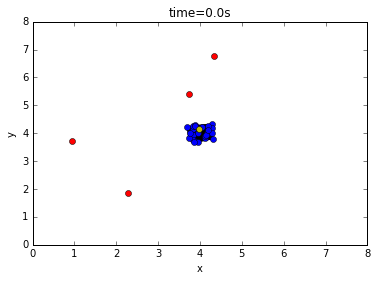

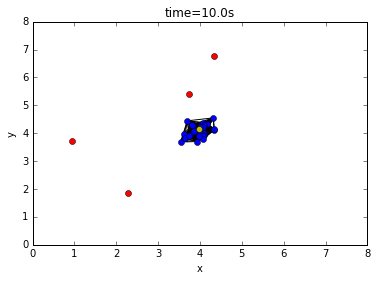

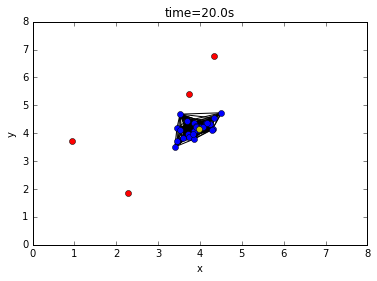

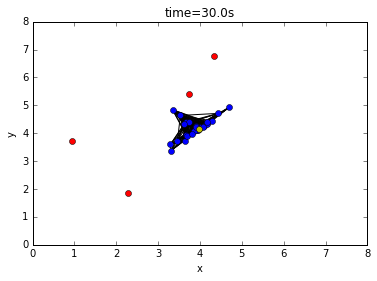

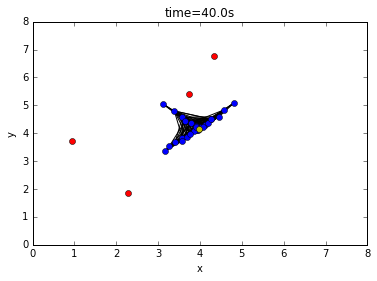

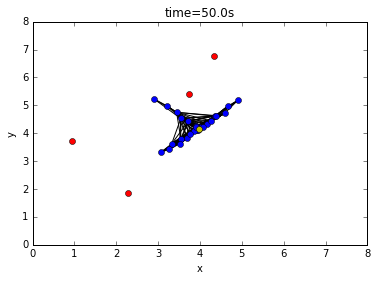

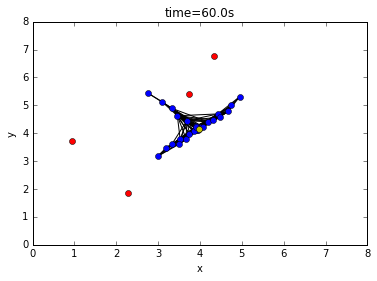

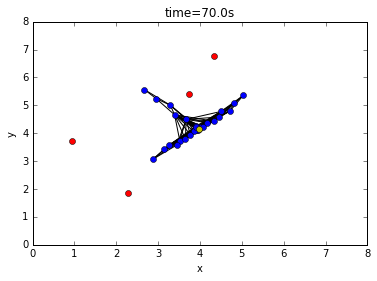

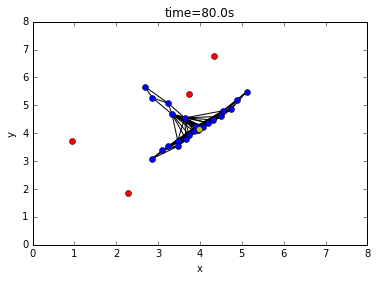

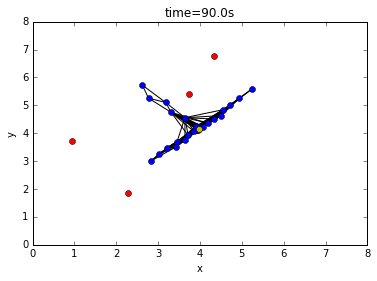

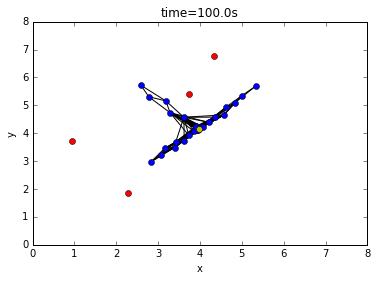

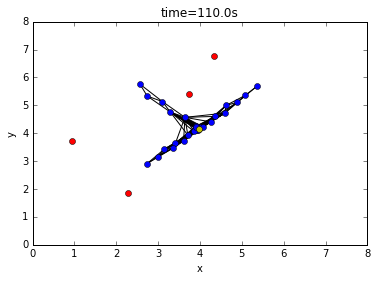

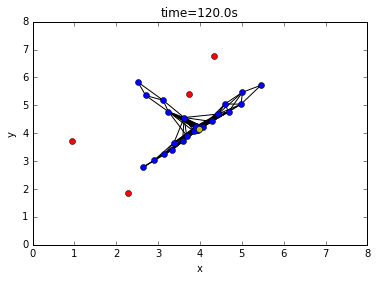

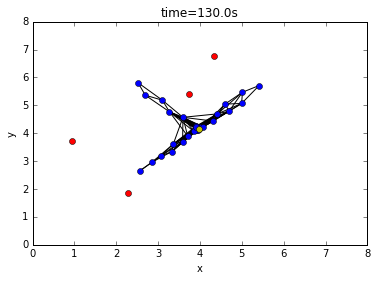

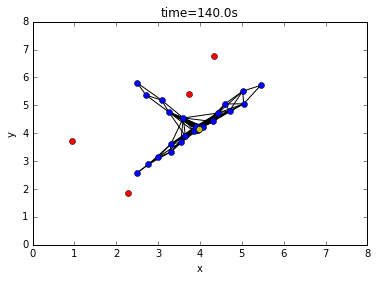

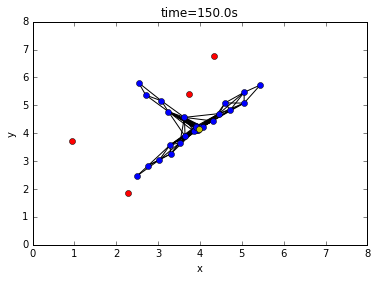

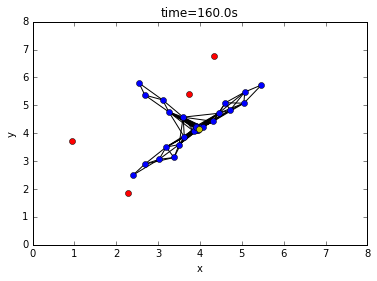

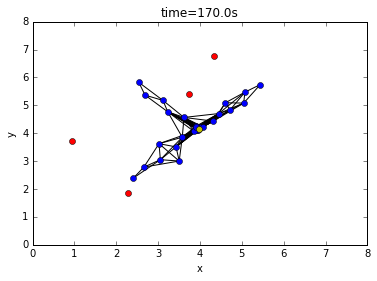

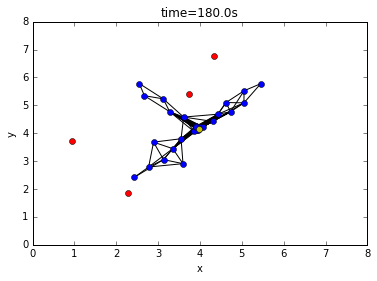

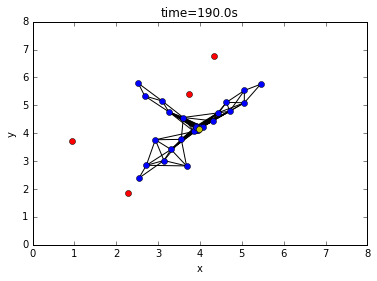

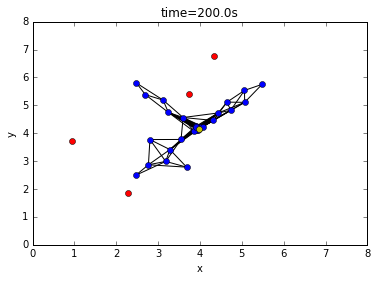

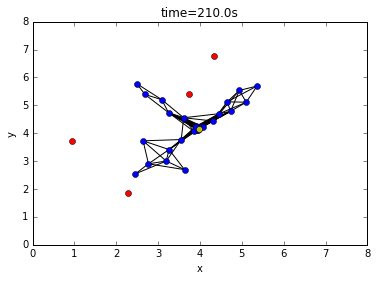

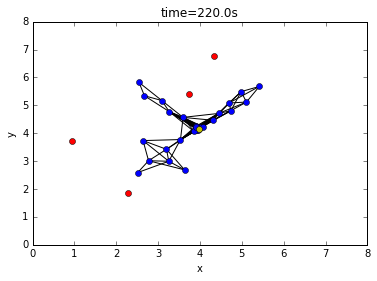

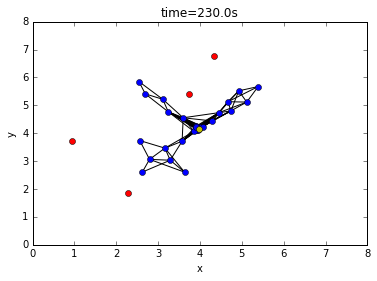

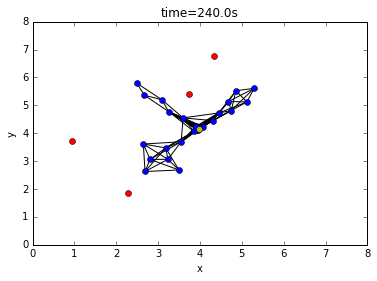

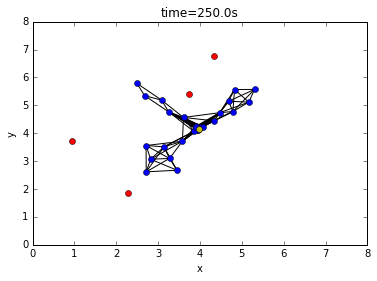

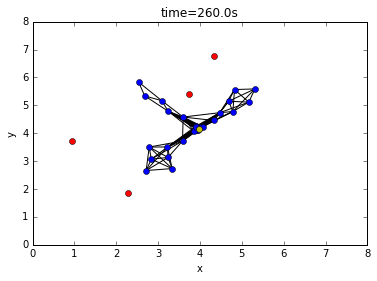

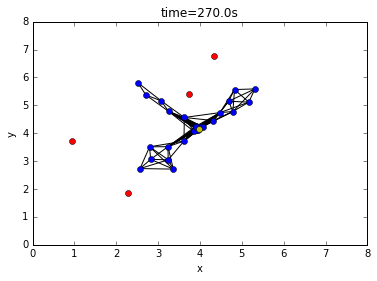

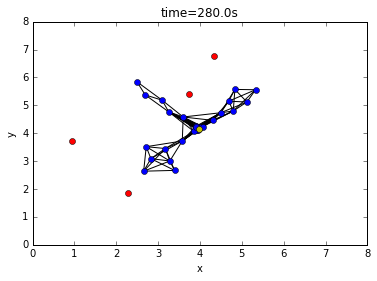

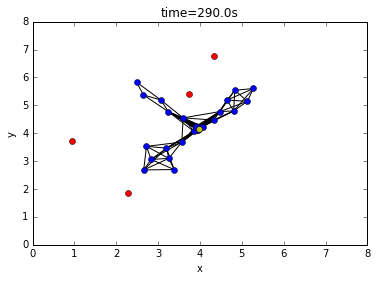

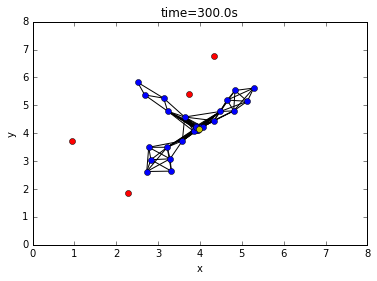

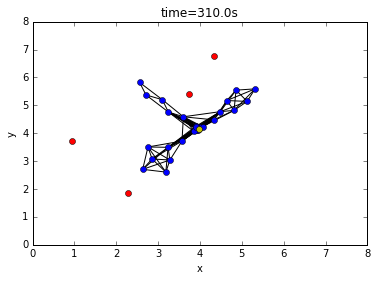

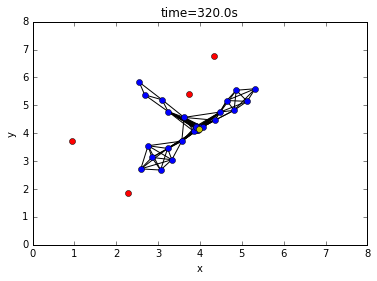

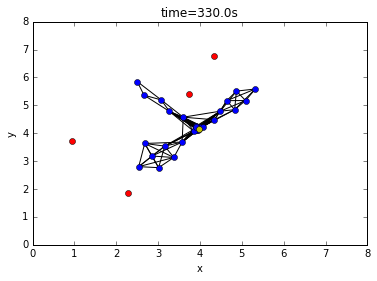

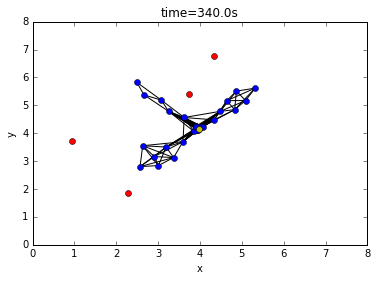

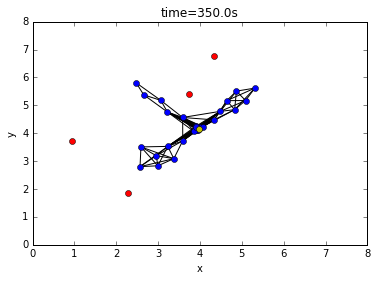

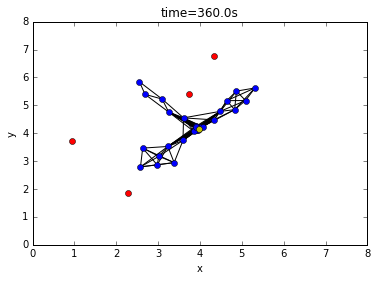

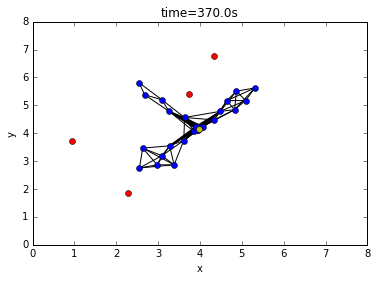

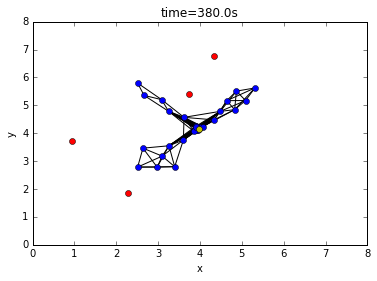

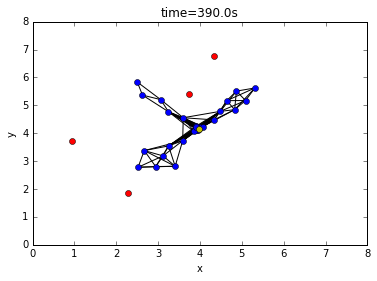

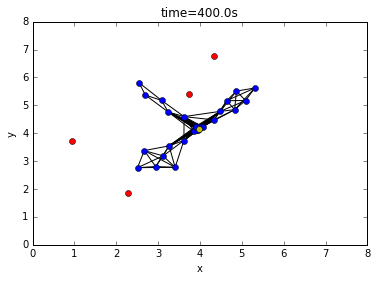

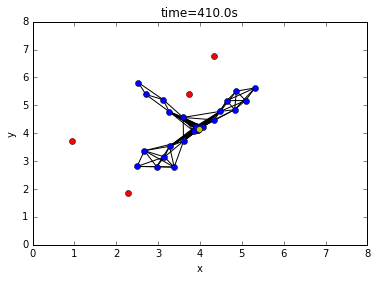

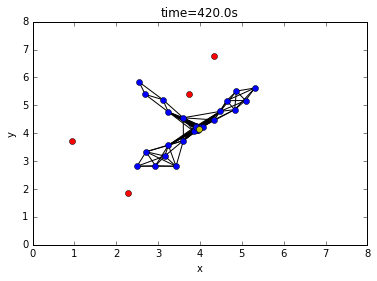

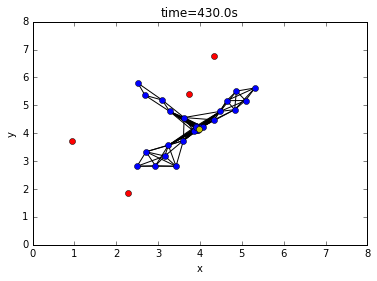

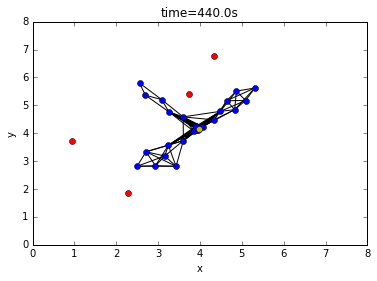

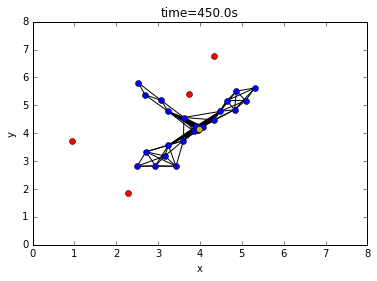

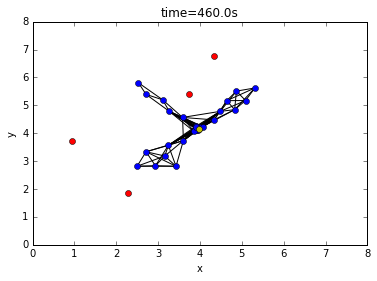

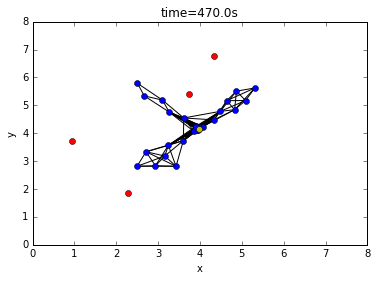

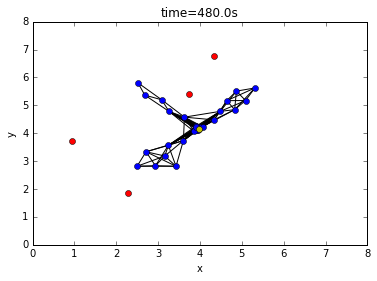

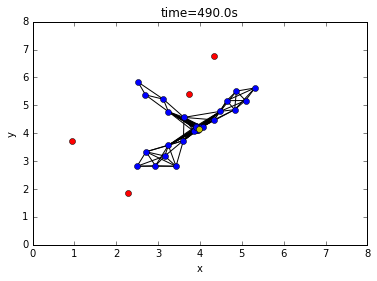

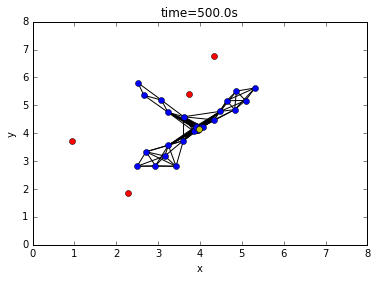

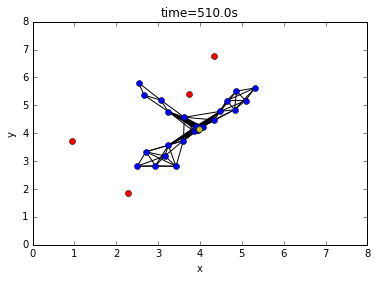

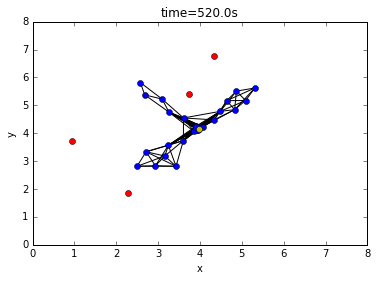

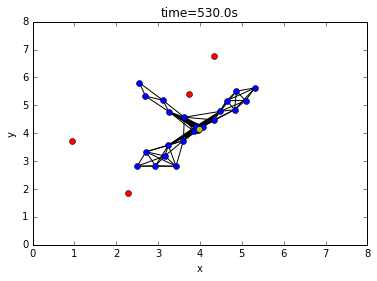

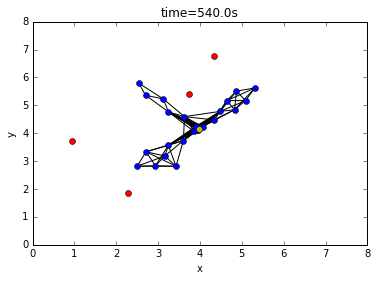

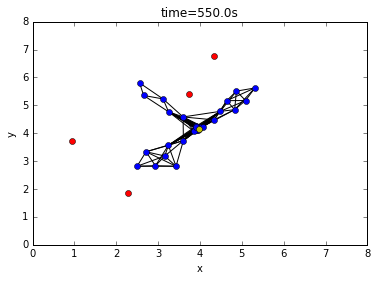

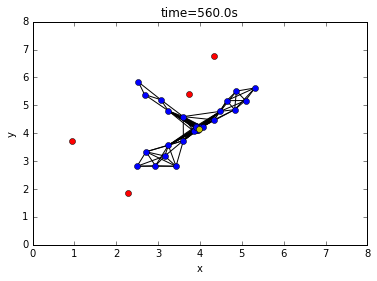

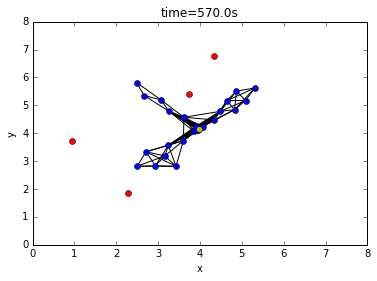

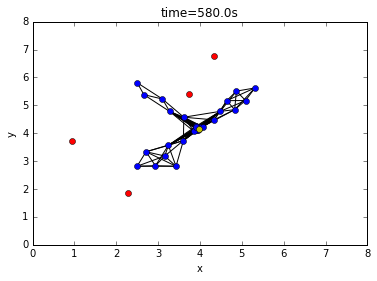

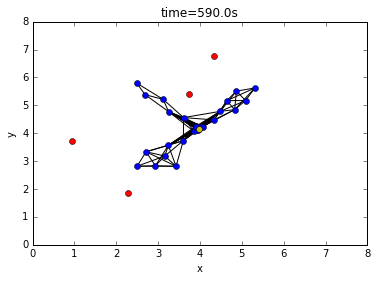

In [2886]:
init()

#positions[0,0] = 4.0
#positions[0,1] = 4.0
#positions[1,0] = 4.0+1.0*math.cos(1.0*math.pi)
#positions[1,1] = 4.0+1.0*math.sin(1.0*math.pi)

for t in range(0,int(H/propagation)):
    seconds = t*propagation
    A = neighbors()
    
    #####################
    #manage communication
    #####################
    
    communicate(A,t)
    
    #####################
    #####################
    
    if seconds%control_step==0:
        
        ###############
        #manage control
        ###############
        
        control(A)
        
        ###############
        ###############
        
    positions = update()                     #move the robots AT EVERY STEP OF THE SIMULATION
    
    if seconds%plot_sampling==0:             #plot
        display(seconds)
        

In [2887]:
#tail
print('Thanks for watching!')

Thanks for watching!
